In [1]:
import numpy as np
import matplotlib.pyplot as plt
import juanfit
from astropy.io import fits
from astropy.nddata import CCDData
from astropy.visualization import ImageNormalize, SqrtStretch, LogStretch, ZScaleInterval
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, SpectralCoord
from astropy.wcs.utils import celestial_frame_to_wcs
import astropy.units as u
from sunpy.coordinates.frames import Helioprojective
from ccdproc import ImageFileCollection
from glob import glob
import os
import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
import dkist
from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd
from reproject import reproject_exact, reproject_exact, reproject_interp
import copy

In [2]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [3]:
def plot_vbi_ds(ds,index,vmin=None,vmax=None):
    fig = plt.figure(figsize=(8,6),constrained_layout=True)
    ax = fig.add_subplot(projection=ds[index,:,:].wcs)
    im = ax.imshow(ds[index,:,:].data,origin="lower",cmap="Greys_r",vmin=vmin,vmax=vmax)
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.grid("on")

    ax.tick_params(labelsize=18,direction="in",which="both")
    ax.tick_params(which="major",length=8,width=1.5)
    plot_colorbar(im, ax, width="5%",fontsize=18)
    ax.set_xlabel(r"SOLAR-X [arcsec]",fontsize=18)
    ax.set_ylabel(r"SOLAR-Y [arcsec]",fontsize=18)
    ax.set_title(r"DKIST/VBI-Blue Ca \textsc{ii} K "+ds.headers[index]["DATE-AVG"][10:19],fontsize=18)

In [4]:
asdf_file = "../src/DKIST/pid_1_118/BJLKB/VBI_L1_20220602T172155_BJLKB.asdf"

In [5]:
ds = dkist.Dataset.from_asdf(asdf_file)

In [6]:
ds[0,0]

This Dataset has 3 pixel and 3 world dimensions

dask.array<stack, shape=(20, 4096, 4096), dtype=float32, chunksize=(1, 4096, 4096), chunktype=numpy.ndarray>

Pixel Dim  Axis Name                  Data size  Bounds
        0  time                              20  None
        1  helioprojective longitude       4096  None
        2  helioprojective latitude        4096  None

World Dim  Axis Name                  Physical Type                   Units
        0  time                       time                            s
        1  helioprojective longitude  custom:pos.helioprojective.lat  arcsec
        2  helioprojective latitude   custom:pos.helioprojective.lon  arcsec

Correlation between pixel and world axes:

             Pixel Dim
World Dim    0    1    2
        0  yes   no   no
        1  yes  yes  yes
        2  yes  yes  yes

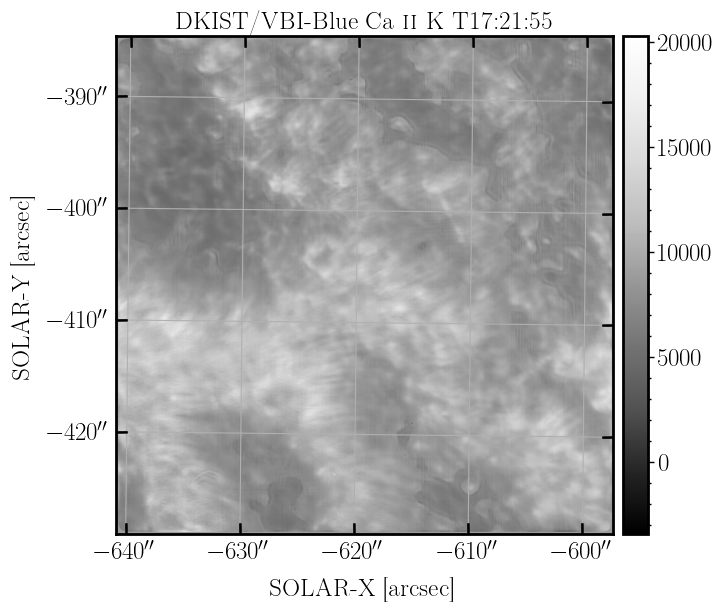

In [7]:
plot_vbi_ds(ds[0,0],0)

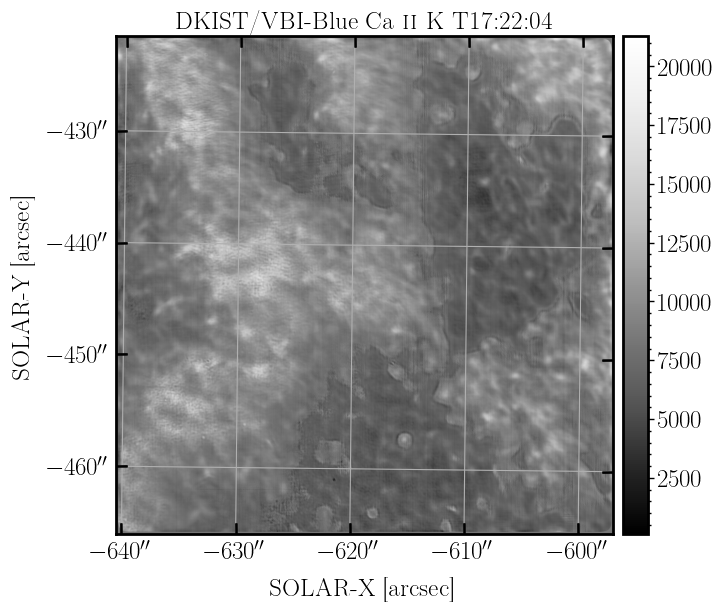

In [8]:
plot_vbi_ds(ds[0,1],0)

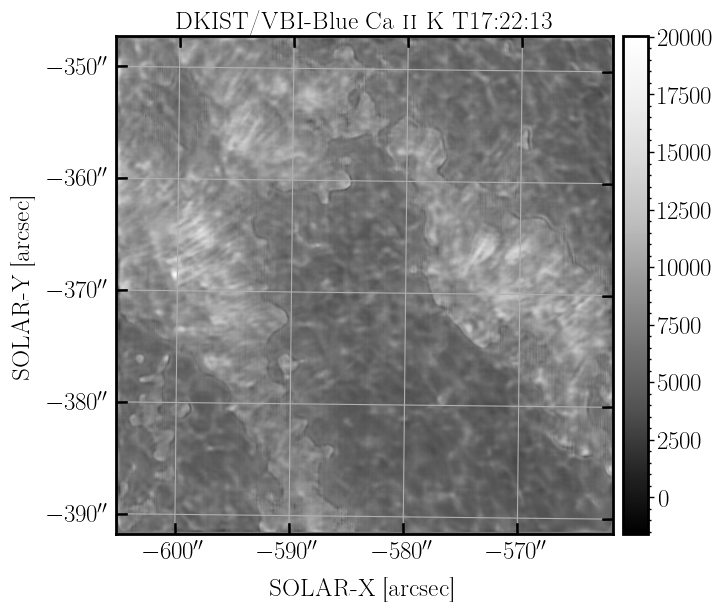

In [9]:
plot_vbi_ds(ds[0,2],0)

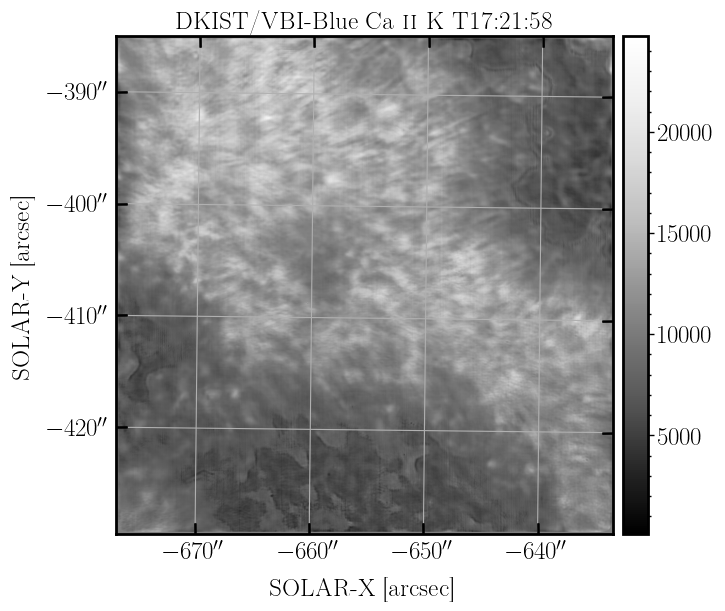

In [10]:
plot_vbi_ds(ds[1,0],0)

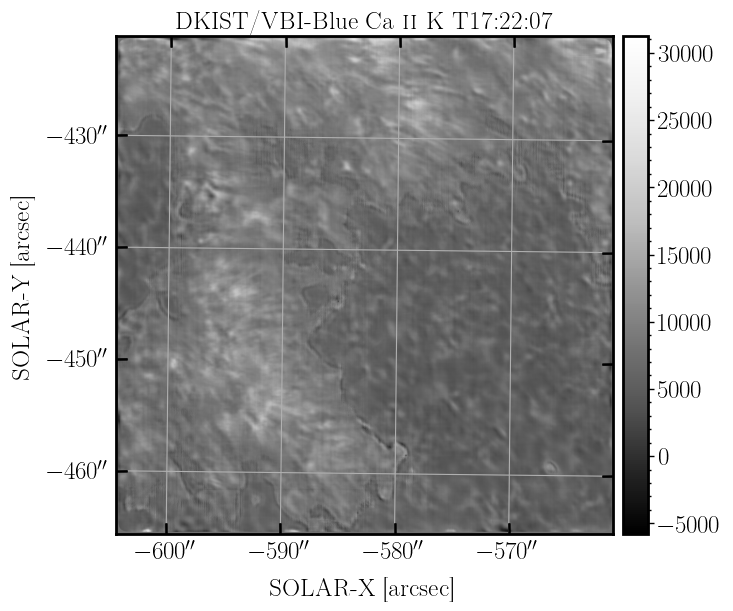

In [11]:
plot_vbi_ds(ds[1,1],0)

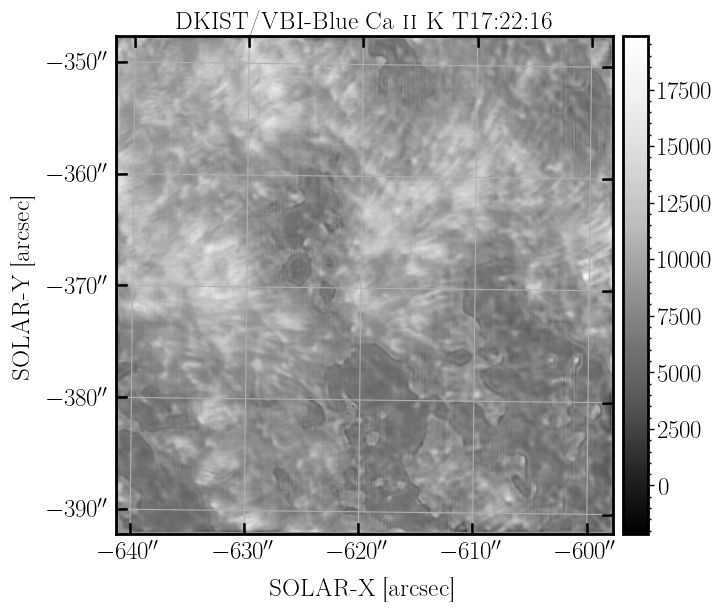

In [12]:
plot_vbi_ds(ds[1,2],0)

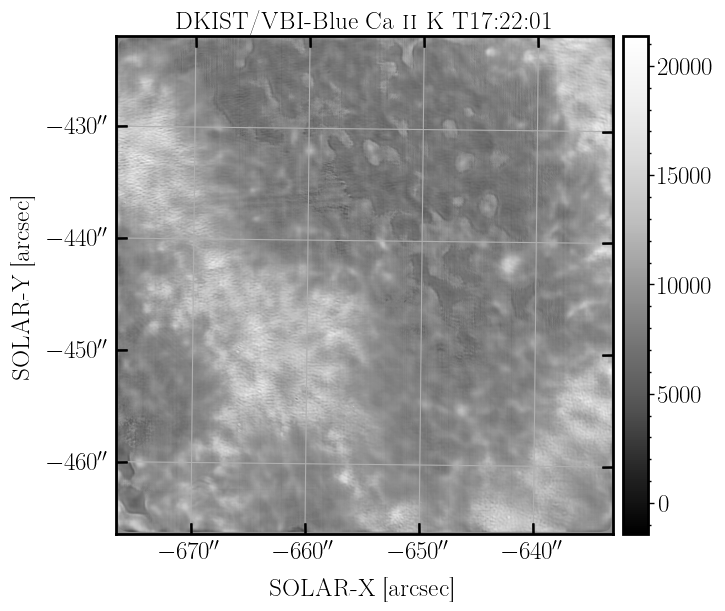

In [13]:
plot_vbi_ds(ds[2,0],0)

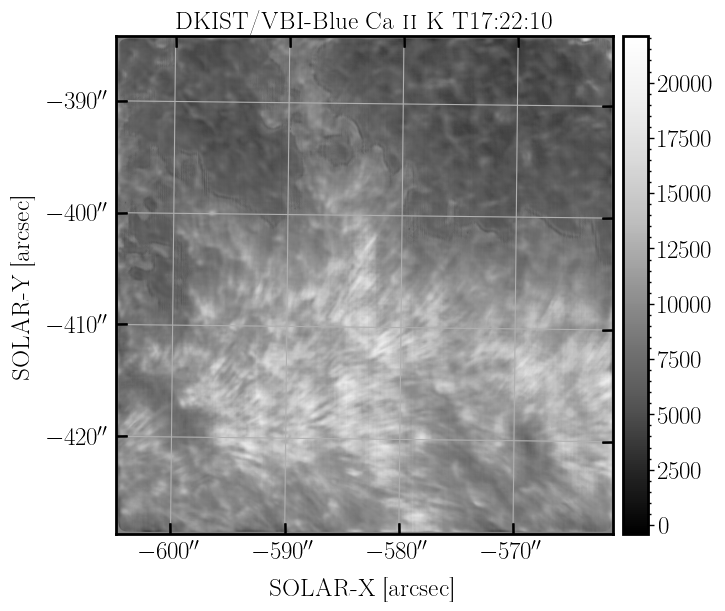

In [14]:
plot_vbi_ds(ds[2,1],0)

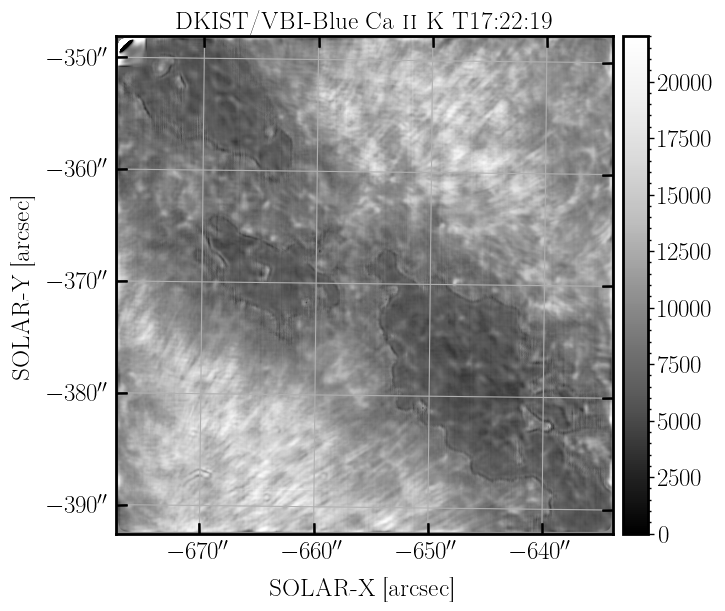

In [15]:
plot_vbi_ds(ds[2,2],0,vmin=0,vmax=22000)

In [16]:
WCS(ds[0,0].headers[0]).celestial.wcs

Set MJD-BEG to 59732.723557 from DATE-BEG.
Set MJD-AVG to 59732.723557 from DATE-AVG.
Set MJD-END to 59732.723557 from DATE-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    20.706700 from OBSGEO-[XYZ].
Set OBSGEO-H to     3063.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


       flag: 137
      naxis: 2
      crpix: 0x4edfac0
               2017.1       2081.6    
         pc: 0x34be9e0
    pc[0][]:   0.96691     -0.010865  
    pc[1][]:   0.011757     0.98713   
      cdelt: 0x4b50190
               3.0556e-06   3.0556e-06
      crval: 0x4ad2440
              -0.17195     -0.11306   
      cunit: 0x54b5f40
             "deg"
             "deg"
      ctype: 0x541ce20
             "HPLN-TAN"
             "HPLT-TAN"
    lonpole: 180.000000
    latpole: -0.113056
    restfrq: 0.000000
    restwav: 0.000000
        npv: 0
     npvmax: 0
         pv: 0x0
        nps: 0
     npsmax: 0
         ps: 0x0
         cd: 0x34e68f0
    cd[0][]:   0.0000       0.0000    
    cd[1][]:   0.0000       0.0000    
      crota: 0x4b560c0
               0.0000       0.0000    
     altlin: 1
     velref: 0
        alt: ' '
     colnum: 0
      colax: 0x514e8b0
                 0      0
      cname: 0x53af860
             UNDEFINED
             UNDEFINED
      crder: 0x4e79b0

In [17]:
ds[0,0].wcs.world_axis_object_classes["celestial"][2]["frame"]

<Helioprojective Frame (obstime=2022-06-02T17:21:55.346, rsun=695700.0 km, observer=None)>

In [18]:
# target_wcs = WCS(naxis=2) #celestial_frame_to_wcs(Helioprojective(obstime=ds[0,0].headers[0]["DATE-AVG"],observer="Earth"))
target_wcs = copy.deepcopy(WCS(ds[0,0].headers[0]).celestial)
# target_wcs.wcs.ctype = 'HPLN-TAN', 'HPLT-TAN'
# target_wcs.wcs.cunit = 'arcsec','arcsec'
# target_wcs.wcs.cdelt = 0.011/3600., 0.011/3600.
target_wcs.wcs.crpix = 6144.5, 6144.5
target_wcs.wcs.crval = -619.0/3600., -413.0/3600.
# target_wcs.pc = np.array([[1,0],[0,1]])
# target_wcs.wcs.obsgeo = WCS(ds[0,0].headers[0]).celestial.wcs.obsgeo

Set MJD-BEG to 59732.723557 from DATE-BEG.
Set MJD-AVG to 59732.723557 from DATE-AVG.
Set MJD-END to 59732.723557 from DATE-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    20.706700 from OBSGEO-[XYZ].
Set OBSGEO-H to     3063.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [19]:
array_test, footprint_test = reproject_and_coadd([(ds[0,0][0,:,:].data.compute(),WCS(ds[0,0].headers[0]).celestial)],
                                           target_wcs, shape_out=(4096*3,4096*3),
                                           reproject_function=reproject_exact,
                                           match_background=False)

Set MJD-BEG to 59732.723557 from DATE-BEG.
Set MJD-AVG to 59732.723557 from DATE-AVG.
Set MJD-END to 59732.723557 from DATE-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    20.706700 from OBSGEO-[XYZ].
Set OBSGEO-H to     3063.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/home/yjzhu/anaconda3/envs/dkist/lib/python3.9/site-packages/reproject/spherical_intersect/core.py:48: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn(


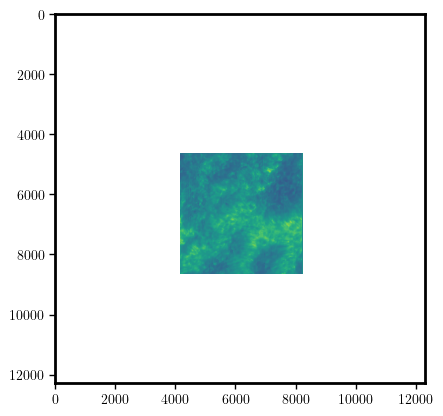

In [20]:
plt.imshow(array_test)

In [59]:
def make_visp_mosaic(tiled_ds,index):

    target_wcs = celestial_frame_to_wcs(Helioprojective(obstime=tiled_ds[0,0].headers[index]["DATE-AVG"],observer="Earth"))
    target_wcs.wcs.ctype = 'HPLN-TAN', 'HPLT-TAN'
    target_wcs.wcs.cunit = 'arcsec','arcsec'
    target_wcs.wcs.cdelt = 0.011, 0.011
    target_wcs.wcs.crpix = 6144.5, 6144.5
    target_wcs.wcs.crval = -619.0, -413.0
    target_wcs.pc = np.array([[1,0],[0,1]])

    wcs_list = []
    for ii in range(3):
        for jj in range(3):
            data = tiled_ds[ii,jj][index,:,:].data.compute()
            # wcs = tiled_ds[ii,jj][index,:,:].wcs
            wcs = WCS(tiled_ds[ii,jj].headers[index]).celestial
            wcs_list.append((data,wcs))
    
    target_shape = (3*4096, 3*4096)

    array, footprint = reproject_and_coadd(wcs_list,
                                           target_wcs, shape_out=target_shape,
                                           reproject_function=reproject_interp,
                                           match_background=False)
    
    return target_wcs, target_shape, array, footprint


In [52]:
target_wcs, target_shape, visp_merg, footprint = make_visp_mosaic(ds,10)

Set MJD-BEG to 59732.733078 from DATE-BEG.
Set MJD-AVG to 59732.733078 from DATE-AVG.
Set MJD-END to 59732.733078 from DATE-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    20.706700 from OBSGEO-[XYZ].
Set OBSGEO-H to     3063.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set MJD-BEG to 59732.733184 from DATE-BEG.
Set MJD-AVG to 59732.733184 from DATE-AVG.
Set MJD-END to 59732.733184 from DATE-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    20.706700 from OBSGEO-[XYZ].
Set OBSGEO-H to     3063.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set MJD-BEG to 59732.733290 from DATE-BEG.
Set MJD-AVG to 59732.733290 from DATE-AVG.
Set MJD-END to 59732.733290 from DATE-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    20.706700 from OBSGEO-[XYZ].
Set OBSGEO-H to     3063.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set MJD-BEG to 59732.733113 from DATE-BEG.
Set MJD-AVG to 59732.733113 from DATE-AVG.
Set MJD-END to 59732.733113 from DATE-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    20.706700 from OBSGEO-[XYZ].
Set OBSGEO-H to

Set MJD-BEG to 59732.723557 from DATE-BEG.
Set MJD-AVG to 59732.723557 from DATE-AVG.
Set MJD-END to 59732.723557 from DATE-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    20.706700 from OBSGEO-[XYZ].
Set OBSGEO-H to     3063.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


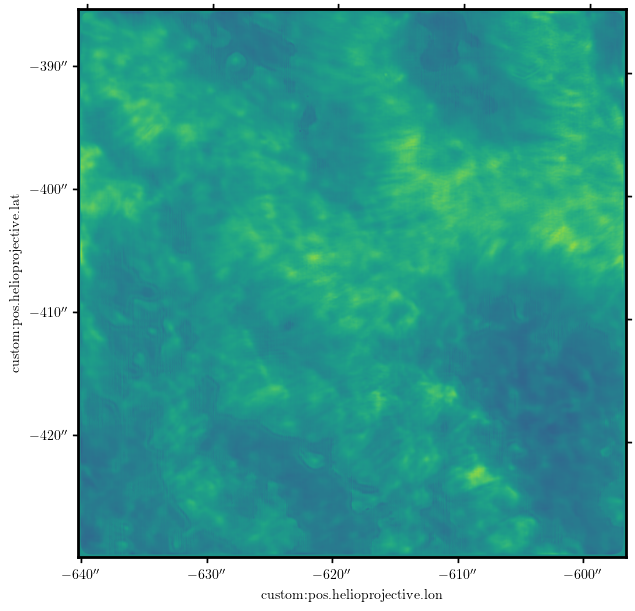

In [53]:
fig = plt.figure(figsize=(8,6),constrained_layout=True)
ax = fig.add_subplot(projection=WCS(ds[0,0].headers[0]).celestial)
ax.imshow(ds[0,0][0,:,:].data.compute(),origin="lower")

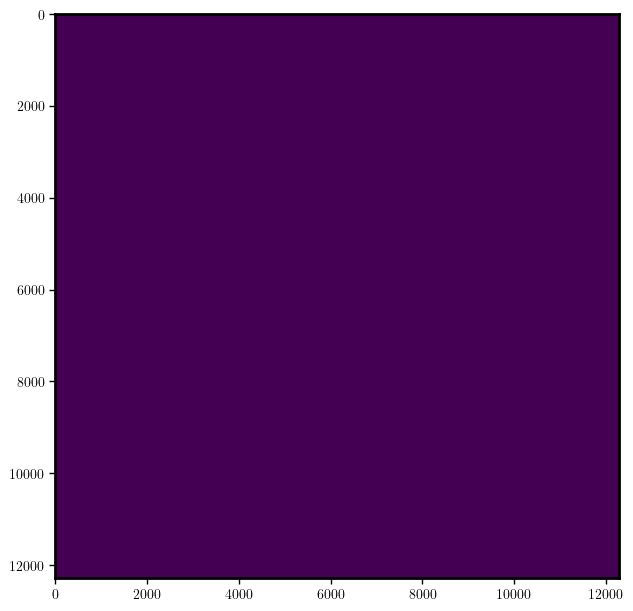

In [54]:
fig = plt.figure(figsize=(8,6),constrained_layout=True)
ax = fig.add_subplot()
ax.imshow(footprint)
# im = ax.imshow(visp_merg,origin="lower",cmap="Greys_r",vmin=0,vmax=25000)
# ax.invert_xaxis()
# ax.invert_yaxis()
# ax.grid("on")

# ax.tick_params(labelsize=18,direction="in",which="both")
# ax.tick_params(which="major",length=8,width=1.5)
# plot_colorbar(im, ax, width="5%",fontsize=18)
# ax.set_xlabel(r"SOLAR-X [arcsec]",fontsize=18)
# ax.set_ylabel(r"SOLAR-Y [arcsec]",fontsize=18)
# ax.set_title(r"DKIST/VBI-Blue Ca \textsc{ii} K "+ds[0,0].headers[10]["DATE-AVG"][10:19],fontsize=18)